In [1]:
import pandas_datareader.data as web
#!pip install yfinance
import yfinance as yf
import pandas as pd
import datetime as dt
import numpy as np

#model packages
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import *
from keras.models import Model
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

In [2]:
#download S&P Data from past 10 years
s = '2010-01-01'
e = '2020-01-01'
#df = web.DataReader('SPY', 'yahoo', start=s, end=e)
df = yf.download("SPY", start=s, end=e)

[*********************100%***********************]  1 of 1 completed


# Derive Features

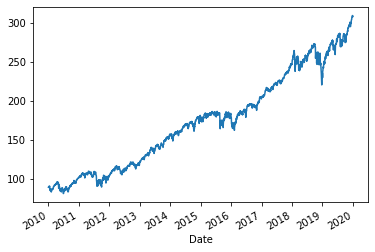

In [3]:
df['Adj Close'].plot()

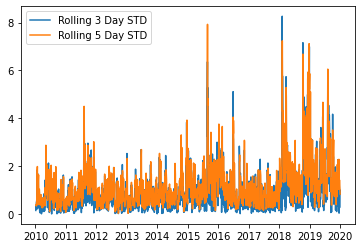

In [4]:
plt.plot(df['Adj Close'].rolling(3).std(), label='Rolling 3 Day STD')
plt.plot(df['Adj Close'].rolling(5).std(), label='Rolling 5 Day STD')
plt.legend()
plt.show()

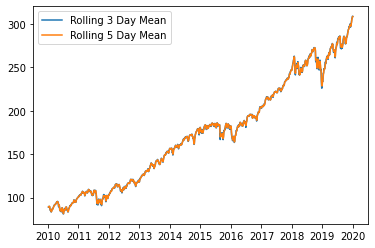

In [5]:
plt.plot(df['Adj Close'].rolling(3).mean(), label='Rolling 3 Day Mean')
plt.plot(df['Adj Close'].rolling(5).mean(), label='Rolling 5 Day Mean')
plt.legend()
plt.show()

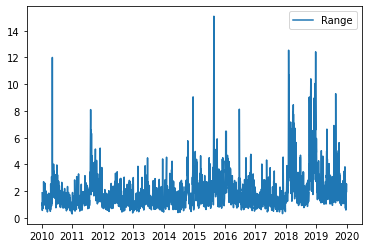

In [6]:
plt.plot((df['High'] - df['Low']), label='Range')
plt.legend()
plt.show()

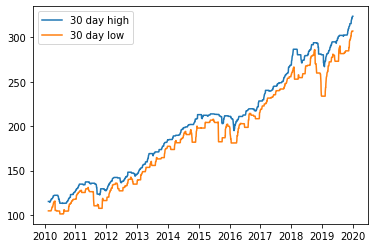

In [7]:
plt.plot(df['High'].rolling(30).max(), label = '30 day high')
plt.plot(df['Low'].rolling(30).min(), label = '30 day low')
plt.legend()
plt.show()

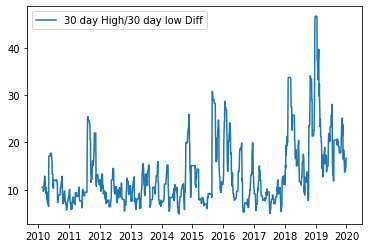

In [8]:
plt.plot((df['High'].rolling(30).max() - df['Low'].rolling(30).min()), label = '30 day High/30 day low Diff')
plt.legend()
plt.show()

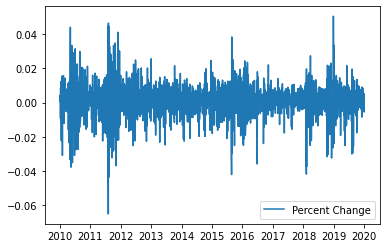

In [9]:
plt.plot(df['Adj Close'].pct_change(), label='Percent Change')
plt.legend()
plt.show()

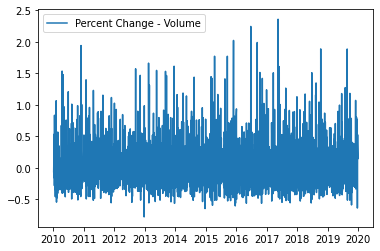

In [10]:
plt.plot(df['Volume'].pct_change(), label='Percent Change - Volume')
plt.legend()
plt.show()

In [5]:
#rolling standard deviation
df['std_3'] = df['Adj Close'].rolling(3).std() #* np.sqrt(256)
df['std_5'] = df['Adj Close'].rolling(5).std() #* np.sqrt(256)
# moving average 3 day and 5 day
df['ma_3'] = df['Adj Close'].rolling(3).mean()
df['ma_5'] = df['Adj Close'].rolling(5).mean()
# range
df['range'] = df['High']-df['Low']
# 30 day High
df['30DHigh'] = df['High'].rolling(30).max()
# 30 day Low
df['30DLow'] = df['Low'].rolling(30).min()
# 30 Day High - Low Difference
df['30DHighLowDiff'] = df['30DHigh'] - df['30DLow']
# change in volume day to day
df['vol_chng'] = df['Volume'].pct_change()

# returns
df['returns'] = df['Adj Close'].pct_change()

# Prepare Data

In [6]:
#drop other columns
df.drop(['Open','Close','High','Low','Adj Close'], axis=1, inplace=True)

In [7]:
df = df.replace(np.NaN,0)

In [8]:
test_set_size = 0.3

df_copy = df

df_train = df_copy.iloc[ : int(np.floor(len(df_copy)*(1-test_set_size)))]
df_test = df_copy.iloc[ int(np.floor(len(df_copy)*(1-test_set_size))) : ]

In [9]:
predictors = ['Volume', 'std_3', 'std_5', 'ma_3', 'ma_5','range','30DHigh','30DLow','30DHighLowDiff','vol_chng']

In [10]:
# restructure the data so that the features are including the data
# only from the prior day and the target variable is the data from
# the current day

train_today = df_train[predictors][:-1]
train_tmrw = df_train['returns'][1:]

test_today = df_test[predictors][:-1]
test_tmrw = df_test['returns'][1:]

# Model 1 - Random Forest Regression

In [11]:
# Create a random forest classification model.  Set min_samples_split high to ensure we don't overfit.
model = RandomForestRegressor()#n_estimators=10, min_samples_split=200, random_state=1)

In [12]:
# predict the next day's returns with today's data
model.fit(X=train_today, y=train_tmrw)

RandomForestRegressor()

In [13]:
preds = model.predict(test_today)

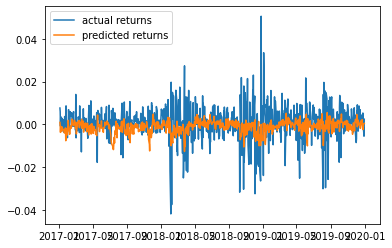

In [14]:
plt.plot(test_tmrw,  label='actual returns')
plt.plot(test_tmrw.index,preds, label='predicted returns')
plt.legend()
plt.show()

In [15]:
def rmse(pred, actual):
    'root mean squared error'
    return np.sqrt(np.sum(np.power(pred-actual,2)/len(pred)))

In [16]:
error_rf_reg = rmse(preds, test_tmrw)

# Model 2 - XGBoost

In [17]:
model1 = xgb.XGBRegressor(n_estimators = 1000,
                        max_depth = 5,
                        min_child_weight = 2,
                        learning_rate = 0.3)

In [18]:
model1.fit(X=train_today, y=train_tmrw)

[15:12:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(learning_rate=0.3, max_depth=5, min_child_weight=2,
             n_estimators=1000)

In [19]:
preds = model1.predict(test_today)

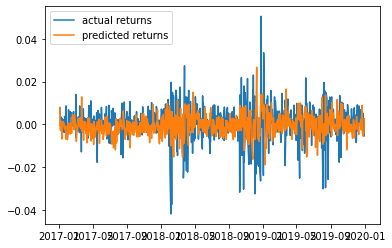

In [20]:
plt.plot(test_tmrw,  label='actual returns')
plt.plot(test_tmrw.index,preds, label='predicted returns')
plt.legend()
plt.show()

In [21]:
error_xg_reg = rmse(preds, test_tmrw)

# Model 3 - CNN

In [22]:
# Normalizing data before model fitting using MinMaxScaler
scaler_train = MinMaxScaler(feature_range=(0,1))
scaled_train = scaler_train.fit_transform(df_train)

scaler_test = MinMaxScaler(feature_range=(0,1))
scaled_test = scaler_test.fit_transform(df_test)

In [23]:
X_scaled_train = []
y_scaled_train = []
for i in range(10, len(scaled_train)):
    X_scaled_train.append(scaled_train[i-10:i, 0:-1])
    y_scaled_train.append(scaled_train[i, -1])

X_train, y_train = np.array(X_scaled_train), np.array(y_scaled_train)
print('Number of rows and columns: ', X_train.shape)

Number of rows and columns:  (1751, 10, 10)


In [24]:
X_scaled_test= []
y_scaled_test = []
for i in range(10, len(scaled_test)):
    X_scaled_test.append(scaled_test[i-10:i, 0:-1])
    y_scaled_test.append(scaled_test[i, -1])

X_test, y_test = np.array(X_scaled_test), np.array(y_scaled_test)
print('Number of rows and columns: ', X_test.shape)

Number of rows and columns:  (745, 10, 10)


In [27]:
## CNN
input_layer = Input(shape=((10,10,1)), dtype='float32')
dense1 = Conv2D(32, kernel_size = 3, activation='relu')(input_layer)
dense2 = Conv2D(32, kernel_size = 3, activation='tanh')(dense1)
flat = Flatten()(dense2)
output_layer = Dense(1, activation='linear')(flat)

cnn = Model(inputs=input_layer, outputs=output_layer)
cnn.compile(loss='mean_squared_error', optimizer='adam')

In [28]:
cnn.fit(x=X_train, y=y_train, batch_size=5, epochs=100, verbose=1, shuffle=True)

Epoch 1/100
351/351 [==============================] - 2s 3ms/step - loss: 0.0167
Epoch 2/100
351/351 [==============================] - 1s 3ms/step - loss: 0.0091
Epoch 3/100
351/351 [==============================] - 1s 3ms/step - loss: 0.0092
Epoch 4/100
351/351 [==============================] - 1s 3ms/step - loss: 0.0085
Epoch 5/100
351/351 [==============================] - 1s 3ms/step - loss: 0.0086
Epoch 6/100
351/351 [==============================] - 1s 3ms/step - loss: 0.0084
Epoch 7/100
351/351 [==============================] - 1s 3ms/step - loss: 0.0082
Epoch 8/100
351/351 [==============================] - 1s 3ms/step - loss: 0.0081
Epoch 9/100
351/351 [==============================] - 1s 3ms/step - loss: 0.0078
Epoch 10/100
351/351 [==============================] - 1s 3ms/step - loss: 0.0078
Epoch 11/100
351/351 [==============================] - 1s 3ms/step - loss: 0.0076
Epoch 12/100
351/351 [==============================] - 1s 3ms/step - loss: 0.0077
Epoch 13/100


In [29]:
preds = cnn.predict(X_test)

24/24 [==============================] - 0s 3ms/step


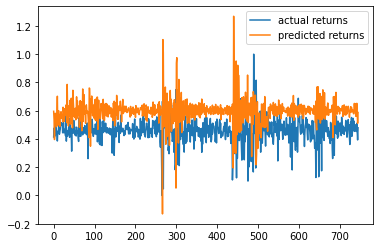

In [30]:
plt.plot(y_test,  label='actual returns')
plt.plot(preds, label='predicted returns')
plt.legend()
plt.show()

In [31]:
error_cnn = rmse(preds, y_test)

# Compare Models

In [32]:
errors = pd.DataFrame({'RandomForest':error_rf_reg,'XGBoost':error_xg_reg,'CNN':error_cnn},index=['RMSE'])

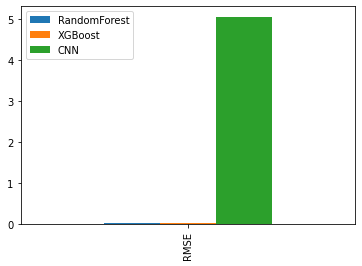

In [33]:
errors.plot(kind='bar')

In [34]:
errors.min()

RandomForest    0.008784
XGBoost         0.009413
CNN             5.055364
dtype: float64

### the ensemble method, Random Forest Regression, seems to work the best and delivers the smallest RMSE of 0.008784